In [34]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import functools 
import operator

from sklearn import utils

import datetime
import csv
#import nltk
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split

In [35]:
# path for the csv files
DATA_PATH = os.path.join(os.getcwd(), 'data')

# loading data to pandas dataframe
def load_data(file_name): 
    file_path = os.path.join(DATA_PATH, file_name) 
    return pd.read_csv(file_path, parse_dates = ['purchase_date', 'release_date'])

def extract_dateinfo(df, col_name, datetype='year'):
    '''
    extract date type into specific year, month, date
    '''
    date_type = {'year': df[col_name].dt.year, 'month': df[col_name].dt.month, 'day': df[col_name].dt.day}[datetype]
    
    df.loc[:, col_name+'_'+ datetype] = date_type
    return df

#Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    for col in features:
        # calculating interquartile range
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR  
        
        # get the indices of outliers for feature col
        outliers_in_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the indices to oulier_indices
        outlier_indices.extend(outliers_in_col)
    
    outlier_indices = Counter(outlier_indices)
    result = list(k for k, v in outlier_indices.items() if v > n)
    
    return result

def process_string(string):
    '''
    split strings in categories/tags/genres 
    make all the words in lowercase
    remove all '-'
    '''
    string = string.lower()
    punctuation = "-"
    
    string = ''.join('' if c.isalpha()==False else c for c in string)
    
    return string

def get_cate_type_data(df, column_name):
    cate_list = list(df[column_name].apply(lambda x: set(x)))
    cate_list = set(functools.reduce(operator.iconcat, cate_list, []))
    return cate_list
    
def count_cate_game(df):
    df_copy = df.copy()
    df_copy = df_copy.transpose()
    return df_copy.astype(bool).sum(axis=1)

def plot_heat_map(corr, figsize=(30, 9)):
    plt.figure(figsize=figsize)
    g = sns.heatmap(corr, annot=True, cmap = "coolwarm")



In [36]:
train_set = load_data('train.csv')
test_set = load_data('test.csv')

In [37]:
# Drop outliers from training data
outliers_to_drop = detect_outliers(train_set, 1 ,['price', 'total_positive_reviews', 'total_negative_reviews'])
train_set.loc[outliers_to_drop]
train_set = train_set.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

# merge training data and testing data 
game_info =  pd.concat(objs=[train_set, test_set], axis=0, sort=False).reset_index(drop=True)

#fill missing purchase date with the most frequent value in purchase_date column
game_info['purchase_date'].fillna(game_info['purchase_date'].mode()[0], inplace=True)


#fille missing number of positive_reviews and negative_reviews with zeros
game_info['total_positive_reviews'].fillna(0.0, inplace=True)
game_info['total_negative_reviews'].fillna(0.0, inplace=True)

#print(game_info.isnull().any().any())
#game_info['total_reviews_count'] = game_info['total_positive_reviews'] + game_info['total_negative_reviews']

#transfer boolean values to 1(true) and 0(false)
game_info['is_free'] = game_info['is_free'].map({False: 0.0, True: 1.0})

# extract year value
## year info
game_info = extract_dateinfo(game_info, 'purchase_date')
game_info = extract_dateinfo(game_info, 'release_date')

## month info
game_info = extract_dateinfo(game_info, 'purchase_date', datetype='month')
game_info = extract_dateinfo(game_info, 'release_date', datetype='month')

game_info['time_interval'] = game_info['purchase_date_year'] - game_info['release_date_year']
game_info.drop(columns=['purchase_date', 'release_date'], inplace=True)

game_info.drop(columns=['id'], inplace=True)

# split strings in the categorical columns
game_info['genres'] = game_info['genres'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['categories'] = game_info['categories'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['tags'] = game_info['tags'].str.split(',').apply(lambda x: list(map(process_string, x)))

temp_cate_ds = game_info[['genres', 'categories', 'tags']]

def __unique_tags__(row):
    col1 = row.iloc[0]
    col2 = row.iloc[1]
    col3 = row.iloc[2]
    one_two = set(col1) | set(col2)
    return list(one_two | set(col3))

game_info.loc[:, 'all_cate'] = temp_cate_ds.apply(__unique_tags__, axis=1)
game_info.loc[:, 'cate_count'] = game_info['all_cate'].apply(lambda x: len(x))

played = game_info['playtime_forever'] == 0

played = played.map({False: 0.0, True: 1.0})
game_info['played'] = played

In [38]:
train_len = train_set.shape[0]
test_len = test_set.shape[0]

(train_len, test_len)

(324, 90)

In [39]:
game_info.head()

,playtime_forever,is_free,price,genres,categories,tags,total_positive_reviews,total_negative_reviews,purchase_date_year,release_date_year,purchase_date_month,release_date_month,time_interval,all_cate,cate_count,played
0,0.000000,0.0,3700.0,"[adventure, casual, indie]","[singleplayer, steamtradingcards, steamcloud]","[indie, adventure, storyrich, casual, atmosphe...",372.0,96.0,2018,2013,7,12,5,"[steamcloud, steamtradingcards, drama, indie, ...",15,1.0
1,0.016667,1.0,0.0,[rpg],"[singleplayer, partialcontrollersupport]","[mod, utilities, rpg, gamedevelopment, singlep...",23.0,0.0,2016,2015,11,8,1,"[utilities, freetoplay, singleplayer, partialc...",7,0.0
2,0.000000,0.0,5000.0,"[adventure, casual, indie]","[singleplayer, fullcontrollersupport, steamtra...","[pointclick, adventure, storyrich, comedy, ind...",3018.0,663.0,2018,2014,7,1,4,"[steamcloud, steamtradingcards, d, indie, clas...",23,1.0
3,1.533333,0.0,9900.0,"[action, rpg]","[singleplayer, multiplayer, steamachievements,...","[medieval, rpg, openworld, strategy, sandbox, ...",63078.0,1746.0,2016,2010,11,3,6,"[horses, steamtradingcards, multiplayer, rpg, ...",23,0.0
4,22.333333,0.0,4800.0,"[action, indie, strategy]","[singleplayer, coop, steamachievements, fullco...","[towerdefense, coop, action, strategy, onlinec...",8841.0,523.0,2018,2012,3,7,6,"[steamcloud, towerdefense, steamtradingcards, ...",25,0.0


In [40]:
num_info = game_info.columns.drop(['genres', 'categories', 'tags', 'playtime_forever'])
num_info

Index(['is_free', 'price', 'total_positive_reviews', 'total_negative_reviews',
       'purchase_date_year', 'release_date_year', 'purchase_date_month',
       'release_date_month', 'time_interval', 'all_cate', 'cate_count',
       'played'],
      dtype='object')

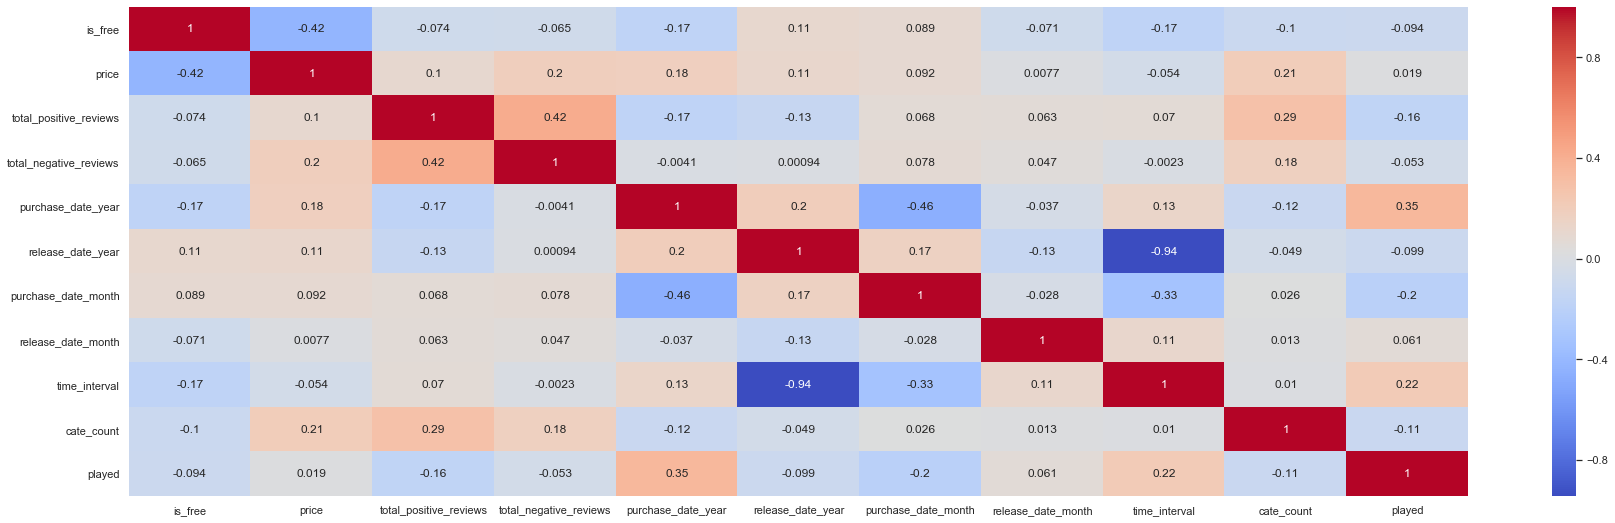

In [41]:
plot_heat_map(game_info.loc[:, num_info].corr())

In [42]:
pd.options.display.max_rows = 4000

cate_dataset = pd.get_dummies(game_info['all_cate'].apply(pd.Series).stack()).sum(level=0)
played = game_info['played']
cate_played = pd.concat([played, cate_dataset], axis=1)

# only delete categories that do not appear in the test set
test_cates = get_cate_type_data(game_info[train_len:], 'all_cate')
train_cates = get_cate_type_data(game_info[:train_len], 'all_cate')
cate_cols = ['played'] + list(test_cates.intersection(train_cates))
cate_played = cate_played[cate_cols]

In [43]:
cate_played.head()

,played,ninja,nudity,freetoplay,partybasedrpg,surreal,datingsim,dark,sexualcontent,illuminati,...,s,underwater,demons,rpgmaker,dplatformer,steampunk,leveleditor,steamleaderboards,cultclassic,historical
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
played_corr = cate_played.corr().loc['played', :]

In [45]:
played_corr.sort_values(ascending=False)

played                            1.000000
scifi                             0.153299
pointclick                        0.139681
horror                            0.137191
beatemup                          0.119343
aliens                            0.119343
destruction                       0.116515
gore                              0.113142
fmv                               0.110636
war                               0.108635
fighting                          0.107703
actionadventure                   0.105924
puzzle                            0.101069
darkhumor                         0.093746
retro                             0.093427
rts                               0.090579
dark                              0.083394
femaleprotagonist                 0.082820
postapocalyptic                   0.079009
classic                           0.078449
blood                             0.077849
masterpiece                       0.076970
oldschool                         0.075109
linear     

In [46]:
game_info[["purchase_date_month", "played"]].groupby(['purchase_date_month'], as_index=False).mean().sort_values(by='played', ascending=False)

,purchase_date_month,played
7,8,0.692308
3,4,0.600000
6,7,0.576923
4,5,0.476190
5,6,0.447761
1,2,0.400000
0,1,0.391304
2,3,0.363636
8,9,0.296296
9,10,0.222222


In [49]:
cate_played[["scifi", "played"]].groupby(['scifi'], as_index=False).mean().sort_values(by='played', ascending=False)

,scifi,played
1,1,0.491071
0,0,0.324503


In [29]:
num_game = count_cate_game(cate_played).drop('played').sort_values(ascending=False)
mid_range_cates = list(num_game[(num_game.values < 240) & (num_game.values > 20)].sort_values().index)
chosen_cates = mid_range_cates
cate_played = cate_played.loc[:, ['played']+ mid_range_cates]
cate_played.head()

,played,medieval,cute,roguelike,building,cyberpunk,futuristic,darkfantasy,familyfriendly,sidescroller,...,scifi,coop,strategy,openworld,rpg,multiplayer,fullcontrollersupport,storyrich,atmospheric,greatsoundtrack
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,1
3,0.0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,0,1


In [51]:
played_corr = cate_played.corr().loc['played', :]
high_corr_tags = list(played_corr[np.abs(played_corr.values) > 0.1 ].drop('played').index)
high_corr_tags

['playerlocal',
 'greatsoundtrack',
 'actionadventure',
 'casual',
 'splitscreen',
 'vr',
 'destruction',
 'rpg',
 'fighting',
 'scifi',
 'localcoop',
 'survival',
 'familyfriendly',
 'fmv',
 'sports',
 'pointclick',
 'massivelymultiplayer',
 'sharedsplitscreen',
 'remoteplayontv',
 'puzzle',
 'aliens',
 'horror',
 'sandbox',
 'gore',
 'onlinecoop',
 'simulation',
 'difficult',
 'beatemup',
 'war',
 'historical']

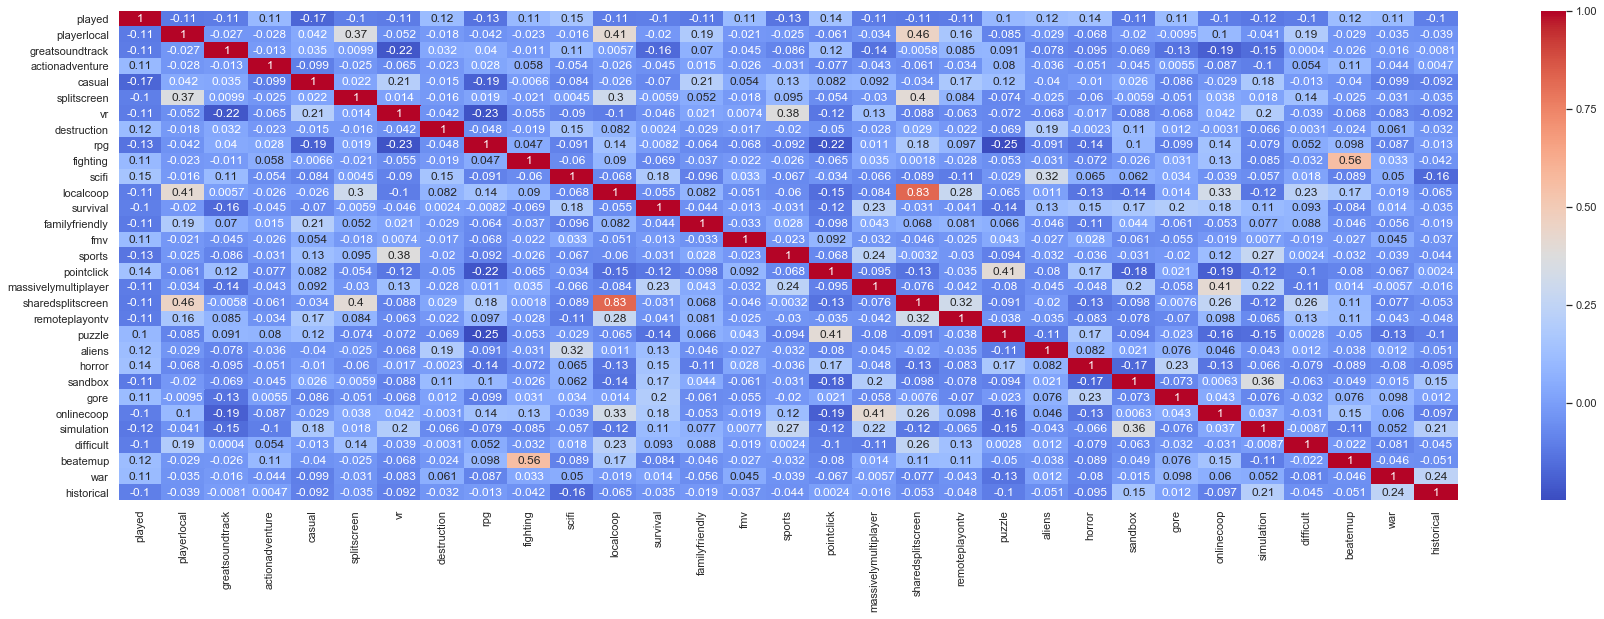

In [55]:
cate_played = cate_played.loc[:, ['played'] + high_corr_tags]
plot_heat_map(cate_played.corr())

In [53]:
temp = cate_played.sort_values(by='played').drop(columns=['played'])[0:159]
#temp = cate_time.sort_values(by='playtime_forever')[159:199]
cols = temp.columns
bt = temp.apply(lambda x: x > 0)
top20 = bt.apply(lambda x: list(cols[x.values]), axis=1)

In [54]:
from collections import Counter 
import itertools
flat_top20 = itertools.chain.from_iterable(top20.values)
flat_top20 = list(flat_top20)

Counter(flat_top20).most_common()

[('greatsoundtrack', 95),
 ('rpg', 62),
 ('casual', 44),
 ('simulation', 37),
 ('scifi', 36),
 ('puzzle', 35),
 ('difficult', 34),
 ('onlinecoop', 32),
 ('survival', 32),
 ('sandbox', 28),
 ('horror', 27),
 ('localcoop', 22),
 ('pointclick', 21),
 ('sharedsplitscreen', 19),
 ('vr', 19),
 ('gore', 17),
 ('historical', 16),
 ('familyfriendly', 13),
 ('massivelymultiplayer', 11),
 ('playerlocal', 7),
 ('remoteplayontv', 7),
 ('sports', 6),
 ('war', 5),
 ('actionadventure', 5),
 ('aliens', 4),
 ('splitscreen', 3),
 ('fmv', 2),
 ('fighting', 2),
 ('beatemup', 2),
 ('destruction', 1)]

In [68]:
def create_new_cate(all_cate_list, new_feature):
    if len(set(all_cate_list).intersection(set(new_feature))) > 0:
        return 1.0
    else:
        return 0.0

In [69]:
cate_corr = cate_played.corr()

cols = cate_corr.columns
bt = cate_corr.apply(lambda x: x > 0.35)
inter_corr = bt.apply(lambda x: list(cols[x.values]), axis=1)

In [72]:
inter_corr

played                                                           [played]
playerlocal             [playerlocal, splitscreen, localcoop, sharedsp...
greatsoundtrack                                         [greatsoundtrack]
actionadventure                                         [actionadventure]
casual                                                           [casual]
splitscreen                 [playerlocal, splitscreen, sharedsplitscreen]
vr                                                           [vr, sports]
destruction                                                 [destruction]
rpg                                                                 [rpg]
fighting                                             [fighting, beatemup]
scifi                                                             [scifi]
localcoop                     [playerlocal, localcoop, sharedsplitscreen]
survival                                                       [survival]
familyfriendly                        

In [76]:
local = inter_corr['playerlocal']
pointclick = inter_corr['pointclick']
multiplayed = inter_corr['massivelymultiplayer']
simulation = inter_corr['simulation']
fighting = inter_corr['fighting']
vr_sports = inter_corr['vr']

['pointclick', 'puzzle']